In [42]:
# CLAIM: The model recovers more spurious ORFs than HMM-based tools 

In [ ]:
import pandas as pd
from utils import *  
import os 
import numpy as np 
from scipy.stats.contingency import expected_freq
import re
from src.files import BLASTJsonFile
import seaborn as sns
from scipy.stats import chisquare

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
def get_chi_square_p_value(observed_counts_df:pd.DataFrame):
    # totals = observed_counts_df.sum(axis=1)
    # Not sure if I should be testing for independence, or using the null that they are equally-distributed. 
    # expected_counts_df = pd.DataFrame(0.5, index=observed_counts_df.index, columns=observed_counts_df.columns)
    # expected_counts_df = expected_counts_df.mul(totals, axis=0)
    expected_counts_df = pd.DataFrame(expected_freq(observed_counts_df), index=observed_counts_df.index, columns=observed_counts_df.columns) # This uses frequencies based on the marginal frequencies.
    p = chisquare(observed_counts_df.values.ravel(), expected_counts_df.values.ravel()).pvalue
    return p

In [90]:
def write_csv(df:pd.DataFrame, path:str=None):
    df = df.copy()
    
    is_overlap_at_query_n_terminus = lambda row : ((row.query_strand == 1) and (row.query_overlap == '10')) or ((row.query_strand == -1) and (row.query_overlap == '01'))
    is_overlap_at_top_hit_n_terminus = lambda row : ((row.top_hit_strand == 1) and (row.top_hit_overlap == '10')) or ((row.top_hit_strand == -1) and (row.top_hit_overlap == '01'))

    df['query_overlap_at_n_terminus'] = df.apply(is_overlap_at_query_n_terminus, axis=1)
    df['top_hit_overlap_at_n_terminus'] = df.apply(is_overlap_at_top_hit_n_terminus, axis=1)
    columns = ['species', 'genome_id', 'top_hit_protein_id', 'top_hit_product', 'top_hit_evidence_type', 'query_overlap_at_n_terminus', 'length', 'top_hit_length', 'overlap_length', 'top_hit_spurious', 'query_rbs_motif']
    df[columns].to_csv(path)
    print(f'write_csv: Wrote {len(df)} sequences to {path}.')

In [45]:
dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)

dataset_df = annotate(dataset_df)
dataset_df['top_hit_hypothetical'] = dataset_df.top_hit_product == 'hypothetical protein'
# Make sure these are in units of amino acids. 
dataset_df['query_length'] = dataset_df.seq.apply(len)
dataset_df['top_hit_length'] = dataset_df.top_hit_seq.apply(len)

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

In [46]:
interpro_df = pd.concat([InterProScanFile(path).to_df() for path in glob.glob('../data/interpro/*')])
ids_with_antifam_hit = interpro_df[interpro_df.interpro_analysis == 'AntiFam'].index.unique()
ids_with_antifam_hit = np.intersect1d(ids_with_antifam_hit, dataset_df.index) # Make sure to remove AntiFam hits from the excluded genomes.
dataset_df['antifam_hit'] = dataset_df.index.isin(ids_with_antifam_hit)

antifam_interpro_df = interpro_df.loc[ids_with_antifam_hit].sort_values('interpro_e_value')
antifam_interpro_df = antifam_interpro_df[~antifam_interpro_df.index.duplicated(keep='first')].copy()

print('Num. proteins with AntiFam hit:', len(ids_with_antifam_hit))
for description, df in antifam_interpro_df.groupby('interpro_signature_description'):
    description = description[0].lower() + description[1:]
    print(f'\tNum. {description}:', len(df))

Num. proteins with AntiFam hit: 27
	Num. antisense to 23S rRNA: 5
	Num. antisense to RNaseP: 2
	Num. translation of CRISPR region: 9
	Num. tRNA translation: 11


In [47]:
threshold = 0.9

results_df = pd.read_csv('../data/results/results-2/dataset_predict.csv', index_col=0)
results_df.columns = [col.replace('_v2', '') for col in results_df.columns]
results_df = results_df.merge(dataset_df, left_index=True, right_index=True, how='inner')
results_df['spurious'] = np.where(results_df.model_output_0 > threshold, True, False)
results_df['real'] = np.where(results_df.model_output_1 > threshold, True, False)
results_df['uncertain'] = ~results_df.real & ~results_df.spurious
results_df['model_label'] = np.select([results_df.real, results_df.spurious.values, results_df.uncertain.values], ['real', 'spurious', 'uncertain'], default='none')

top_hit_results_df = pd.read_csv('../data/results/results-2/top_hits_predict.csv', index_col=0)
top_hit_results_df.columns = [col.replace('_v2', '') for col in top_hit_results_df.columns]
top_hit_results_df = top_hit_results_df[~top_hit_results_df.index.duplicated(keep='first')].copy()

with pd.option_context('future.no_silent_downcasting', True):
    results_df['top_hit_real'] = results_df.top_hit_protein_id.map(top_hit_results_df.model_output_1 > threshold).fillna(False).astype(bool)
    results_df['top_hit_spurious'] = results_df.top_hit_protein_id.map(top_hit_results_df.model_output_0 > threshold).fillna(False).astype(bool)
    results_df['top_hit_uncertain'] = results_df.top_hit_protein_id.map((top_hit_results_df.model_output_0 <= threshold) & (top_hit_results_df.model_output_1 <= threshold)).fillna(False).astype(bool)
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_real, 'real', 'none')
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_spurious, 'spurious', results_df.top_hit_model_label)
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_uncertain, 'uncertain', results_df.top_hit_model_label)

In [48]:
# All but three of the non-coding conflicts are predicted to be spurious. What are the characteristics of the ones which are predicted to be real with high confidence?
for row in results_df[is_non_coding_conflict(results_df) & (results_df.model_label != 'spurious')].itertuples():
    print(row.Index, f'{row.model_label}, {row.model_output_1 * 100:.2f}% confidence')
    print(f'top_hit_feature: {row.top_hit_feature}')
    print(f'top_hit_note: {row.top_hit_note}')
    print('same_strand:', row.same_strand, 'query_strand:', row.query_strand)
    print('overlap_length:', row.overlap_length, f'{row.query_overlap_fraction * 100:.2f}% of query')
    print(f'genome: {row.genome_id}, on contig {row.top_hit_contig_id}, ({row.query_start}, {row.query_stop})')
    print()

NZ_JAIKTU010000008.1_127 real, 100.00% confidence
top_hit_feature: CDS
top_hit_note: incomplete; partial in the middle of a contig; missing N-terminus; Derived by automated computational analysis using gene prediction method: Protein Homology.
same_strand: False query_strand: 1
overlap_length: 228 13.64% of query
genome: GCF_019753795.1, on contig NZ_JAIKTU010000008, (150850, 152520)

NZ_NIGF01000030.1_1 uncertain, 10.26% confidence
top_hit_feature: rRNA
top_hit_note: Derived by automated computational analysis using gene prediction method: cmsearch.
same_strand: True query_strand: 1
overlap_length: 117 20.10% of query
genome: GCF_002973605.1, on contig NZ_NIGF01000030, (2, 583)

NZ_QXIU01000029.1_3 real, 95.94% confidence
top_hit_feature: CDS
top_hit_note: incomplete; partial in the middle of a contig; missing C-terminus; Derived by automated computational analysis using gene prediction method: Protein Homology.
same_strand: False query_strand: 1
overlap_length: 439 85.08% of query
ge

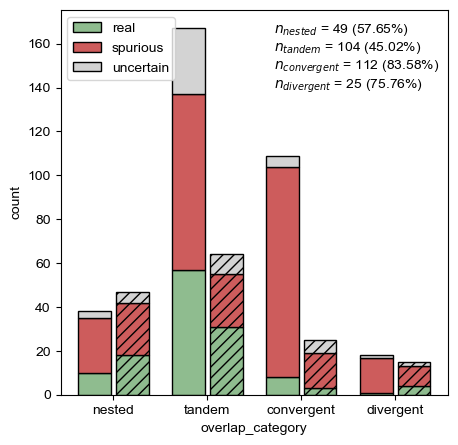

In [74]:
def figure(results_df:pd.DataFrame):
    figure_df = results_df[is_cds_conflict(results_df)].copy()

    fig, ax = plt.subplots(figsize=(5, 5))
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.4

    def panel_a(ax_df:pd.DataFrame, offset:float=None, hatch=None, add_label:bool=True):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for model_label, df in ax_df.groupby('model_label'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=model_label if add_label else '', color=palette[model_label], width=width - 0.05, hatch=hatch, )
            bottom += np.array(heights)
            totals += heights
            
    panel_a(figure_df[~figure_df.top_hit_hypothetical], offset=-width/2)
    panel_a(figure_df[figure_df.top_hit_hypothetical], offset=width/2, hatch='///', add_label=False)
    ax.set_xticks(positions, labels=overlap_types)
    ax.set_ylabel('count')
    ax.set_xlabel('overlap_category')
    ax.legend(loc='upper left')

    text = ''
    for category in ['nested', 'tandem', 'convergent', 'divergent']:
        text += get_text(category, ((figure_df.overlap_type == category) & (figure_df.spurious)).sum(), (figure_df.overlap_type == category).sum())
    ax.text(0.55, 0.75, text, transform=ax.transAxes)

    plt.show()


figure(results_df)

In [57]:
# Might be good to take a closer look at the antiparallel-conflicting proteins predicted to be real with high confidence.
# There are too many spurious predictions to look at in any depth. 

df = results_df[is_antiparallel_cds_conflict(results_df) & results_df.real].copy()

n_hypothetical = (df.top_hit_product != 'hypothetical protein').sum()
n_unsupported = ((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction')).sum()

print('Num. real-predicted antiparallel conflicts with hypothetical proteins:', n_hypothetical, f'({get_percent(n_hypothetical, len(df))})')
print('Num. real-predicted antiparallel conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, len(df))})', end='\n\n')

for overlap_type in ['divergent', 'convergent']:
    n_hypothetical = ((df.top_hit_product != 'hypothetical protein') & (df.overlap_type == overlap_type)).sum()
    n_unsupported = ((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction') & (df.overlap_type == overlap_type)).sum()

    print(f'Num. real-predicted {overlap_type} conflicts with hypothetical proteins:', n_hypothetical, f'({get_percent(n_hypothetical, (df.overlap_type == overlap_type).sum())})')
    print(f'Num. real-predicted {overlap_type} conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, (df.overlap_type == overlap_type).sum())})', end='\n\n')

columns = ['species', 'genome_id', 'top_hit_protein_id', 'top_hit_product', 'top_hit_evidence_type', 'phase', 'length', 'top_hit_length', 'overlap_length', 'spans_assembly_gap', 'overlap_type']
df['spans_assembly_gap'] = df.seq.str.count('X') > 2
df[columns].to_csv('../data/results/results-2/antiparallel_real.csv')

# Export the Prodigal-predicted and reference sequences for InterPro annotation and BLAST alignment.
write_fasta(df, path='../data/results/results-2/antiparallel_real.faa', add_top_hit=True)

# pd.crosstab(df.overlap_type, df.phase)

Num. real-predicted antiparallel conflicts with hypothetical proteins: 9 (56.25%)
Num. real-predicted antiparallel conflicts with unsupported proteins: 6 (37.50%)

Num. real-predicted divergent conflicts with hypothetical proteins: 1 (20.00%)
Num. real-predicted divergent conflicts with unsupported proteins: 4 (80.00%)

Num. real-predicted convergent conflicts with hypothetical proteins: 8 (72.73%)
Num. real-predicted convergent conflicts with unsupported proteins: 2 (18.18%)

write_fasta: Wrote 32 sequences to ../data/results/results-2/antiparallel_real.faa


In [ ]:
# IDs from the tandem overlaps which are likely due to a fragmented protein; from results-2-2-si2.ipynb.
tandem_fragment_ids = ['NZ_JAALLS010000037.1_4', 'NZ_JAALLS010000005.1_1', 'NZ_CP063767.1_1564', 'NZ_JAYGHR010000002.1_180', 'NZ_JAYGHR010000010.1_46', 'NZ_JAYGHR010000095.1_4', 'NC_021487.1_586', 'NZ_JAIKTU010000005.1_51', 'NZ_QXIU01000121.1_2', 'NZ_QXIU01000013.1_4', 'NZ_QXIU01000201.1_20', 'NZ_QXIU01000258.1_3', 'NZ_QXIU01000037.1_8', 'NZ_QXIU01000048.1_21', 'NZ_QXIU01000073.1_4', 'NZ_QXIU01000088.1_2', 'NZ_CP018099.1_1950', 'NZ_AP025523.1_725', 'NZ_AP025523.1_1853', 'NZ_AP025523.1_2690', 'NZ_CP130454.1_336', 'NZ_CP130454.1_2358', 'NZ_CP130454.1_3138', 'NZ_CP130454.1_3168', 'NC_015499.1_1072', 'NZ_NIGF01000012.1_26', 'NZ_NIGF01000022.1_4', 'NC_014960.1_288', 'NC_014960.1_2737', 'NZ_AP035449.1_427', 'NZ_AP035449.1_1439']

# Interestingly, results on the fragmented tandem overlaps seems inconsistent. 
# results_df.loc[tandem_fragment_ids].value_counts(['top_hit_hypothetical', 'model_label'])
write_fasta(results_df.loc[tandem_fragment_ids], path=f'../data/results/results-2/tandem_fragmented.faa', add_top_hit=True)
write_csv(results_df.loc[tandem_fragment_ids], path=f'../data/results/results-2/tandem_fragmented.csv')


write_fasta: Wrote 62 sequences to ../data/results/results-2/tandem_fragmented.faa
write_csv: Wrote 31 sequences to ../data/results/results-2/tandem_fragmented.csv.


Num. real +1 overlaps: 7 (9.46%)
Num. real +4 overlaps: 33 (44.59%)
Num. real phase +1 overlaps: 25 (33.78%)
Num. real phase +2 overlaps: 49 (66.22%)


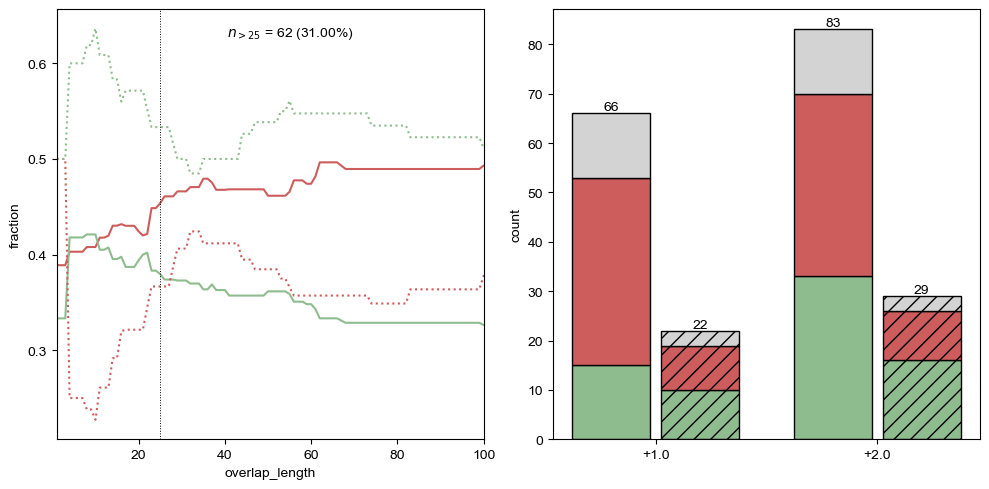

In [80]:
def si_figure(results_df:pd.DataFrame, overlap_type:str='antiparallel', width:float=0.4, overlap_length:int=30, exclude_ids:list=None):

    if overlap_type == 'antiparallel':
        figure_df = results_df[is_antiparallel_cds_conflict(results_df)].copy()
    else:
        figure_df = results_df[is_tandem_cds_conflict(results_df)].copy()
        figure_df = figure_df[figure_df.phase != 0].copy()

    if exclude_ids is not None:
        figure_df = figure_df[~figure_df.index.isin(exclude_ids)].copy()

    fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}

    def panel_a(figure_df:pd.DataFrame, ax:plt.Axes=None, linestyle:str='-'):
        min_overlap_length = figure_df.overlap_length.min()
        overlap_lengths = np.arange(min_overlap_length, 400)

        ax_df = pd.DataFrame(index=overlap_lengths, columns=['uncertain', 'real', 'spurious', 'hypothetical'])
        ax_df['overlap_length'] = overlap_lengths

        for overlap_length in overlap_lengths:
            df = figure_df[figure_df.overlap_length <= overlap_length]
            ax_df.loc[overlap_length, 'spurious'] = df.spurious.sum() / len(df)
            ax_df.loc[overlap_length, 'real'] = df.real.sum() / len(df)
        sns.lineplot(data=ax_df[~ax_df.spurious.isnull()], x='overlap_length', y='spurious', color='indianred', ax=ax, linestyle=linestyle)
        sns.lineplot(data=ax_df[~ax_df.real.isnull()], x='overlap_length', y='real', color='darkseagreen', ax=ax, linestyle=linestyle)

        ax.set_ylabel('fraction')
        ax.set_xlim(xmax=100, xmin=1)

    def panel_b(ax_df:pd.DataFrame, ax=None, offset:float=None, hatch:str=None):
        phases = sorted(figure_df.phase.unique())
        # ax_df = ax_df[ax_df.overlap_length > 7]

        positions = np.arange(len(phases)) + offset
        totals = ax_df.groupby('phase').apply(len, include_groups=False).loc[phases]
        bottom = np.zeros(len(phases))

        for model_label, df in ax_df.groupby('model_label'):
            heights = np.array([(df.phase == phase).sum() for phase in phases])
            ax.bar(positions, heights, bottom=bottom, edgecolor='black', label=model_label, color=palette[model_label], hatch=hatch, width=width - 0.05)
            bottom += np.array(heights)

        for x, y in zip(positions, totals):
            ax.text(x, y, str(int(y)), ha='center', va='bottom')

        ax.set_xticks(np.arange(len(phases)), labels=[f'+{phase}' for phase in phases])
        ax.set_ylabel('count')
    
    panel_a(figure_df[~is_top_hit_hypothetical(figure_df)].copy(), ax=ax_a)
    panel_a(figure_df[is_top_hit_hypothetical(figure_df)], ax=ax_a, linestyle=':')

    ax_a.text(0.4, 0.9, get_text(f'>{overlap_length}', (figure_df.overlap_length > overlap_length).sum(), len(figure_df)), transform=ax_a.transAxes)
    ax_a.axvline(overlap_length, ls=':', lw=0.7, color='black')

    panel_b(figure_df[is_top_hit_hypothetical(figure_df)], ax=ax_b, offset=width/2, hatch='//')
    panel_b(figure_df[~is_top_hit_hypothetical(figure_df)], ax=ax_b, offset=-width/2)

    figure_df = figure_df[figure_df.real].copy()
    print('Num. real +1 overlaps:', (figure_df.overlap_length == 1).sum(), f'({get_percent((figure_df.overlap_length == 1).sum(), len(figure_df))})')
    print('Num. real +4 overlaps:', (figure_df.overlap_length == 4).sum(), f'({get_percent((figure_df.overlap_length == 4).sum(), len(figure_df))})')
    print('Num. real phase +1 overlaps:', (figure_df.phase == 1).sum(), f'({get_percent((figure_df.phase == 1).sum(), len(figure_df))})')
    print('Num. real phase +2 overlaps:', (figure_df.phase == 2).sum(), f'({get_percent((figure_df.phase == 2).sum(), len(figure_df))})')

    fig.tight_layout()
    plt.show()

# si_figure(results_df, overlap_length=25)
si_figure(results_df, overlap_length=25, overlap_type='tandem', exclude_ids=tandem_fragment_ids)


In [92]:
model_label = 'real'

# Export the Prodigal-predicted and reference sequences for InterPro annotation and BLAST alignment.
write_fasta(results_df[is_tandem_cds_conflict(results_df) & (results_df.overlap_length > 60) & results_df[model_label]], path=f'../data/results/results-2/tandem_{model_label}.faa', add_top_hit=True)
write_csv(results_df[is_tandem_cds_conflict(results_df) & (results_df.overlap_length > 60) & results_df[model_label]], path=f'../data/results/results-2/tandem_{model_label}.csv')

write_fasta: Wrote 22 sequences to ../data/results/results-2/tandem_real.faa
write_csv: Wrote 11 sequences to ../data/results/results-2/tandem_real.csv.


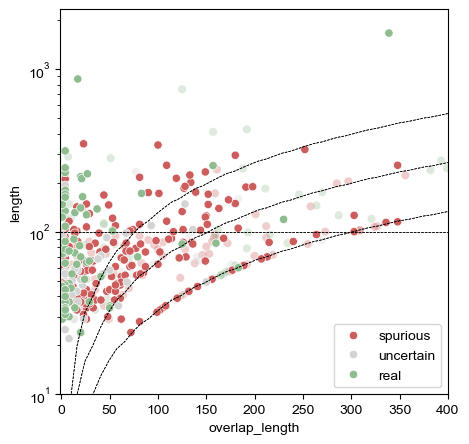

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

figure_df = results_df[is_cds_conflict(results_df)].copy()

palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}

def panel_b(ax_df:pd.DataFrame, ax=None, hypothetical:bool=False):
    ax_df = ax_df.sort_values('model_output_1')
    sns.scatterplot(ax_df, hue='model_label', palette=palette, ax=ax, x='overlap_length', y='length', alpha=0.3 if hypothetical else 1, legend=not hypothetical)
    # sns.move_legend(ax, loc='upper left')
    ax.set_xlim(xmax=400)
    ax.set_yscale('log')
    # ax_a.set_ylim(ymax=300)
    
    # ax.axvline(x=overlap_length, color='black', ls='--', lw=0.5)
    ax.axhline(y=100, color='black', ls='--', lw=0.5)
    
    for overlap_fraction in [0.25, 0.5, 1]:
        x = np.linspace(0, 400, 50) # Overlap length. 
        y = (1 / overlap_fraction) * (x // 3)
        sns.lineplot(x=x, y=y, color='black', ls='--', lw=0.5)

panel_b(figure_df[figure_df.top_hit_hypothetical].copy(), ax=ax, hypothetical=True)
panel_b(figure_df[~figure_df.top_hit_hypothetical].copy(), ax=ax)
ax.set_xlim(xmin=-1)
ax.set_ylim(ymin=10)
plt.show()


In [ ]:
# df = get_nested_results_df(results_df)
# df['parent_overlap_fraction'] = df.parent_overlap_fraction > 0.5
# df['daughter_smorf'] = df.daughter_length < 100
# df['parent_smorf'] = df.parent_length < 100

# variables = ['same_strand', 'parent_overlap_fraction', 'parent_hypothetical', 'daughter_smorf', 'parent_smorf']
# for variable in variables:
#     observed_counts_df = pd.crosstab(df[variable], df['daughter_model_label'])
#     # observed_counts_df = pd.crosstab(df[variable], df['daughter_model_label'])
#     expected_counts_df = pd.DataFrame(expected_freq(observed_counts_df), index=observed_counts_df.index, columns=observed_counts_df.columns) # This uses frequencies based on the marginal frequencies.
#     p = chisquare(observed_counts_df.values.ravel(), expected_counts_df.values.ravel()).pvalue * len(variables)
#     print(variable, p)
#     # table_df.loc[variable, field] =  # Apply the Bonferroni correction. 

# # Why would daughter sequences which make up smaller portions of the parent sequence be less likely to be spurious? 
# # My first guess would be length, but this seems to have a much smaller effect. My second guess is that a smaller overlap fraction 
# # implies that the parent sequence is longer, and therefore less likely to be spurious. 

# # Nearly all of the daughter sequences are hypothetical, only 5 are annotated. This implies that pretty much all of the annotated 
# # sequences are parents. 

# # It's really hard to get anything meaningful out of the nested sequence analysis, as so many are hypothetical.


In [ ]:
# def get_nested_results_df(results_df):
#     results_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'nested')].copy()

#     df = pd.DataFrame(index=results_df.index)
#     df['query_nested'] = results_df.query_length < results_df.top_hit_length
#     df['parent_length'] = np.where(df.query_nested, results_df.top_hit_length, results_df.query_length)
#     df['daughter_length'] = np.where(~df.query_nested, results_df.top_hit_length, results_df.query_length)
#     df['parent_model_label'] = np.where(df.query_nested, results_df.top_hit_model_label, results_df.model_label)
#     df['daughter_model_label'] = np.where(~df.query_nested, results_df.top_hit_model_label, results_df.model_label)
#     df['daughter_real'] = df.daughter_model_label == 'real'
#     df['daughter_spurious'] = df.daughter_model_label == 'spurious'
#     df['parent_real'] = df.parent_model_label == 'real'
#     df['parent_spurious'] = df.parent_model_label == 'spurious'
#     df['parent_overlap_fraction'] = df.daughter_length / df.parent_length
#     df['parent_hypothetical'] =  np.where(df.query_nested, results_df.top_hit_product == 'hypothetical protein', True) 
#     df['daughter_hypothetical'] =  np.where(~df.query_nested, results_df.top_hit_product == 'hypothetical protein', True) 
#     df['same_strand'] = results_df.same_strand
#     df['daughter_id'] = np.where(df.query_nested, results_df.index, results_df.top_hit_protein_id) 
#     df['parent_id'] = np.where(~df.query_nested, results_df.index, results_df.top_hit_protein_id) 
#     df['parent_product'] = np.where(df.query_nested, results_df.top_hit_product, 'hypothetical protein') 
#     df['daughter_product'] = np.where(~df.query_nested, results_df.top_hit_product, 'hypothetical protein') 
    
#     return df 

# # Seems more straightforward to look at things as parent vs. daughter genes in a nested pair. 

In [ ]:
# def si_figure(results_df:pd.DataFrame, model_label:str='real', text_position=(0.1, 0.7)):

#     fig, ax = plt.subplots(figsize=(5, 5))

#     # palettes = {'real':{'convergent':'darkseagreen', 'divergent':'seagreen'}, 'spurious':{'convergent':'indianred', 'divergent':'firebrick'}}
#     alphas = {'convergent':1, 'divergent':0.5}
#     color = 'indianred' if (model_label == 'spurious') else 'darkseagreen'

#     figure_df = results_df[is_antiparallel_cds_conflict(results_df)].copy()
#     phases = sorted(figure_df.phase.unique())
#     totals = figure_df.phase.value_counts().loc[phases].values 

#     p = get_chi_square_p_value(pd.crosstab(figure_df['phase'], figure_df['model_label']))
#     print(f'p={p}')
#     figure_df = figure_df[figure_df.model_label == model_label].copy()

#     width = 0.4 
#     # palette = palettes[model_label]
#     positions = np.arange(len(phases))
#     offsets = {'convergent': width / 2, 'divergent':-width / 2}
#     hatches = {True:'///', False:None}

#     def panel(ax_df:pd.DataFrame, offset:float=None, ax:plt.Axes=None, label:str=None, bottom=np.zeros(len(phases))):
#         for top_hit_hypothetical, df in ax_df.groupby('top_hit_hypothetical'):
#             heights = np.array([((df.phase == phase)).sum() for phase in phases])
#             ax.bar(positions + offset, heights, bottom=bottom, color=color, hatch=hatches[top_hit_hypothetical], edgecolor='black', width=width, label=label if (not top_hit_hypothetical) else None, alpha=alphas[label])
#             bottom += heights 
#         return bottom

#     for overlap_type in ['convergent', 'divergent']:
#         ax_df = figure_df[(figure_df.overlap_type == overlap_type)].copy()
#         panel(ax_df, offset=offsets[overlap_type], label=overlap_type, ax=ax, bottom=np.zeros(len(phases)))

#     text = ''
#     for i, n in enumerate(figure_df.phase.value_counts().loc[phases].values):
#         text += '$n_{' + f'+{int(i)}' + '}' + f'={n}$ ({get_percent(n, totals[i])})\n'
#     # ax.text(0.35, 0.8, text, transform=ax.transAxes)
#     ax.text(*text_position, text, transform=ax.transAxes)

#     ax.legend()
#     ax.set_xticks(positions, labels=[f'+{int(phase)}' for phase in phases])
#     ax.set_xlabel('phase')
#     ax.set_ylabel('count')

#     fig.tight_layout()

# si_figure(results_df, model_label='real', text_position=(0.45, 0.65))
# si_figure(results_df, model_label='spurious', text_position=(0.1, 0.65))

In [ ]:
# # TODO: Compute and report Mann-Whitney test statistics for the ECDF curve differences. 
# # TODO: Should I mention the fact that overlap length is confounded by overlap orientation?
# # TODO: Statistical test showing differences in the antisense vs. sense composition of spurious- and real-labeled sequences. 
# # "Because antisense conflicts are generally larger than sense conflicts (SI Figure 3.2.2), it is unclear if overlap length is itself significant, 
# # or if the observed difference is a byproduct of model sensitivity to antisense overlap."

# def si_figure_3(results_df:pd.DataFrame):
#     '''
#     (A) A summary of model predictions on conflicting sequences; the fraction of antisense conflicts in each category is indicated by the hatched fill. 
#     Spurious-labeled sequences conflicting with supported CDS are significantly more likely to overlap on the antisense strand (p < 1e-11) than their real-labeled counterparts.
#     This effect is far less pronounced for sequences conflicting with unsupported CDS (p > 1e-2).
    
#     (B) ECDF curves of the overlap lengths for conflicts with supported (solid lines) and unsupported (dashed lines) CDS; p_spurious and p_real 
#     are the percentages of conflicts with supported CDS which exceed 10 amino acids in length. Spurious-labeled sequences conflicting with supported CDS have substantially larger
#     overlaps than their real-labeled counterparts. Interestingly, there is no significant difference in the ECDF curves of spurious- and real-classified sequences in conflict with
#     unsupported CDS. The results presented in (A) and (B) suggest that the model is not sensitive to conflict with unsupported CDS.'''

#     figure_df = results_df[results_df.conflict][['top_hit_feature', 'same_strand', 'model_label', 'top_hit_hypothetical', 'overlap_length', 'antifam_hit', 'query_overlap_fraction']].copy()
#     figure_df['conflict_with_cds'] = figure_df.top_hit_feature == 'CDS'
#     figure_df['conflict_with_unsupported_cds'] = (figure_df.top_hit_feature == 'CDS') & (figure_df.top_hit_hypothetical)
#     figure_df['conflict_with_confirmed_cds'] = (figure_df.top_hit_feature == 'CDS') & (~figure_df.top_hit_hypothetical)
#     figure_df['conflict_with_non_coding'] = ~figure_df.conflict_with_cds

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)

#     width = 0.4
#     offsets = {'real': -width/2, 'spurious':width/2}

#     ax_a_df = figure_df.copy()
#     categories = ['confirmed_cds', 'unsupported_cds', 'non_coding']
#     conditions = [ax_a_df.conflict_with_confirmed_cds, ax_a_df.conflict_with_unsupported_cds, ax_a_df.conflict_with_non_coding]
#     ax_a_df['category'] = np.select(conditions, categories, default='none')
#     ax_a_df['model_label'] = np.where(ax_a_df.model_label == 1, 'real', 'spurious')

#     palette = {'real':'darkseagreen', 'spurious':'indianred'}
#     for model_label, df in ax_a_df.groupby('model_label'):
#         ax_df = pd.DataFrame(index=categories)
#         ax_df['total'] = df.category.value_counts()
#         ax_df['fraction'] = df.groupby('category', observed=True).apply(lambda df : (df.same_strand).sum() / len(df), include_groups=False)
#         ax_df['same_strand'] = ax_df['total'] * ax_df['fraction']
#         ax_df['opposite_strand'] = ax_df['total'] * (1 - ax_df['fraction'])
#         positions = np.arange(ax_a_df.category.nunique())
#         ax_a.bar(positions + offsets[model_label], ax_df.opposite_strand,color=palette[model_label], edgecolor='black', hatch='//', width=width)
#         ax_a.bar(positions + offsets[model_label], ax_df.same_strand, bottom=ax_df.opposite_strand, color=palette[model_label], edgecolor='black', width=width)

#         for x, total in zip(positions + offsets[model_label], ax_df.total):
#             text = total
#             ax_a.text(x, total, text, ha='center', fontsize='small', va='bottom')

#     ax_a.set_xticks(positions, labels=ax_df.index)
#     ax_a.set_ylabel('count')

#     text = ''
#     for category, df in ax_a_df.groupby('category'):
#         n = (df.model_label == 'spurious').sum()
#         category = category.replace('_', ' ').replace('cds', '')
#         text += '$p_{' + category + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
#     ax_a.text(0.5, 0.7, text, transform=ax_a.transAxes, fontsize='small')


#     ax_b_df = figure_df[figure_df.conflict_with_cds].copy()
#     ax_b_df['overlap_length'] = ax_b_df.overlap_length // 3 # Convert to units of amino acids. 
#     ax_b_df['model_label'] = np.where(ax_b_df.model_label == 0, 'spurious', 'real')
#     palette = {'real':'darkseagreen', 'spurious':'indianred'}
#     sns.ecdfplot(ax=ax_b, data=ax_b_df[ax_b_df.top_hit_hypothetical], hue='model_label', x='overlap_length', palette=palette, ls=':')
#     sns.ecdfplot(ax=ax_b, data=ax_b_df[~ax_b_df.top_hit_hypothetical], hue='model_label', x='overlap_length', palette=palette)

#     text = ''
#     overlap_length = 10
#     for model_label, df in ax_b_df[~ax_b_df.top_hit_hypothetical].groupby('model_label'):
#         n_overlap_greater_than = (df.overlap_length > overlap_length).sum()
#         text += '$p_{' + model_label + '>' + str(overlap_length) + '}$' + f' = {get_percent(n_overlap_greater_than, len(df))} ($n={n_overlap_greater_than}$)\n'
#     ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes, fontsize='small')
#     ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

#     ax_b.set_xlim(xmax=200, xmin=0)
#     ax_b.set_title('CDS overlap')
#     ax_b.set_ylabel('proportion')

#     fig.tight_layout()
#     plt.show()

# # Could add some annotation to panel A... What summary statistics might be helpful?
# si_figure_3(results_df)

In [ ]:
    # for same_strand, df in figure_df.groupby('same_strand'):
    #     ax_a_df = pd.DataFrame(index=categories)
    #     ax_a_df['total'] = df.category.value_counts()
    #     ax_a_df['log_total'] = np.log10(ax_a_df['total'] + 0.5)
    #     ax_a_df['fraction'] = df.groupby('category').apply(lambda df : df.top_hit_hypothetical.sum() / len(df), include_groups=False)
    #     ax_a_df['unsupported'] = ax_a_df['log_total'] * ax_a_df['fraction']
    #     ax_a_df['supported'] = ax_a_df['log_total'] * (1 - ax_a_df['fraction'])

    #     ax_a.bar(positions + offsets[same_strand], ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', hatch='///', width=width)
    #     ax_a.bar(positions + offsets[same_strand], ax_a_df.supported, bottom=ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', width=width)
        
    #     for x, total, log_total in zip(positions + offsets[same_strand], ax_a_df.total, ax_a_df.log_total):
    #         # text = f'{100 * total / ax_a_df.total.sum():.2f}%'
    #         text = str(total)
    #         ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

In [ ]:
# is_partial_at_c_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == -1) or ((partial[-1] == '1') and (strand == 1))
# is_partial_at_n_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == 1) or ((partial[-1] == '1') and (strand == -1))

# is_query_partial_at_c_terminus = lambda row : is_partial_at_c_terminus(row.query_strand, row.query_partial)
# is_top_hit_partial_at_n_terminus = lambda row : ((row.top_hit_partial == '01') and (row.top_hit_strand == 1)) or ((row.top_hit_partial == '10') and (row.top_hit_strand == -1))
# is_top_hit_cds = lambda row : (row.top_hit_feature == 'CDS') and not row.top_hit_pseudo

# # Overlaps greater than 60 bp are almost certainly spurious. However, the proteins could still be in-frame with a genuine ORF, and the 
# # overlap may be the result of a boundary error. Sequences can be extended at the N-terminus due to erroneous start-codon selection, or extended 
# # at the C-terminus due to a frameshift mutation. N-terminal extensions are the most common cause of overlap, and also the simplest to detect, 
# # so will probably limit analysis to these. 

# # Conflicts that are potentially the result of N-terminal extension include:
# # (1) Divergent overlaps where one or both sequence coordinates are the product of ab initio prediction. 
# # (2) Tandem overlaps where the downstream sequence coordinates are the product of ab initio prediction. 
# # (2) Nested overlaps where one or both sequence coordinates are the product of ab initio prediction. 

# query_start_in_top_hit = lambda df : (df.query_start <= df.top_hit_stop) & (df.query_start >= df.top_hit_start)
# query_stop_in_top_hit = lambda df : (df.query_stop <= df.top_hit_stop) & (df.query_stop >= df.top_hit_start)
# top_hit_start_in_query = lambda df : (df.top_hit_start <= df.query_stop) & (df.top_hit_start >= df.query_start)
# top_hit_stop_in_query = lambda df : (df.top_hit_stop <= df.query_stop) & (df.top_hit_stop >= df.query_start)

# is_conflict_at_query_n_terminus = lambda df : (df.query_strand == 1) & query_start_in_top_hit(df) | ((df.query_strand == -1) & query_stop_in_top_hit(df))
# is_conflict_at_top_hit_n_terminus = lambda df : ((df.top_hit_strand == 1) & top_hit_start_in_query(df) | ((df.top_hit_strand == -1) & top_hit_stop_in_query(df)))

# def get_alternate_coordinates(nt_seq:str=None, start:int=None, stop:int=None, strand:int=None, codon_start:int=1, partial:str=None):
    
#     if nt_seq == 'none':
#         return np.array([start]), np.array([stop])
#     nt_seq = nt_seq[int(codon_start) - 1:]
    
#     start_codons = ['AUG', 'GUG', 'UUG']
#     codons = np.array([nt_seq[i:i + 3] for i in range(0, len(nt_seq) + 1, 3)])
#     start_codon_idxs = np.where(np.isin(codons, start_codons))[0]
#     # WP_259095463.1 does not seem to have a start codon?
#     if len(start_codon_idxs) == 0:
#         return np.array([start]), np.array([stop])
    
#     assert (len(nt_seq) % 3 == 0) or is_partial_at_c_terminus(strand, partial), f'get_alternate_coordinates: Nucleotide sequence length should be divisible by three, got {len(nt_seq)}.'
#     assert len(''.join(codons)) == len(nt_seq), 'get_alternate_coordinates: Joined codons should have the same length as the original nucleotide sequence.'
#     # assert len(start_codon_idxs) >= 1 or is_partial_at_n_terminus(strand, partial), f'get_alternate_starts: Should be at least one start codon. {nt_seq}'

#     start_codon_idxs = 3 * start_codon_idxs

#     if strand == 1:
#         starts = start + start_codon_idxs
#         stops = np.array([stop] * len(starts))
#     elif strand == -1:
#         stops = stop - start_codon_idxs 
#         starts = np.array([start] * len(stops))
#     return starts, stops 

# has_overlap = lambda row : not ((row.query_stop < row.top_hit_start) or (row.query_start > row.top_hit_stop))
# get_overlap_length = lambda row : 0 if not has_overlap(row) else min(row.query_stop, row.top_hit_stop) - max(row.query_start, row.top_hit_start)
# get_overlap_type = lambda row : reference.get_overlap_type(query_start=row.query_start, query_stop=row.query_stop, subject_start=row.top_hit_start, subject_stop=row.top_hit_stop, query_strand=row.query_strand, subject_strand=row.top_hit_strand)

# is_top_hit_coordinate_adjustable = lambda row : is_top_hit_cds(row) and not (('programmed frameshift' in row.top_hit_note) | (row.top_hit_evidence_source == 'similar to AA sequence'))

# def get_configurations(row):
#     query_starts, query_stops = get_alternate_coordinates(start=row.query_start, stop=row.query_stop, strand=row.query_strand, nt_seq=row.query_nt_seq, partial=row.query_partial)
#     if is_top_hit_coordinate_adjustable(row):
#         top_hit_starts, top_hit_stops = get_alternate_coordinates(start=row.top_hit_start, stop=row.top_hit_stop, strand=row.top_hit_strand, nt_seq=row.top_hit_nt_seq, partial=row.top_hit_partial, codon_start=row.top_hit_codon_start)
#     else:
#         top_hit_starts, top_hit_stops = ([row.top_hit_start], [row.top_hit_stop])

#     df = list()
#     for query_start, query_stop in zip(query_starts, query_stops):
#         for top_hit_start, top_hit_stop in zip(top_hit_starts, top_hit_stops):
#             config_info = {'query_start':query_start, 'top_hit_start':top_hit_start, 'query_stop':query_stop, 'top_hit_stop':top_hit_stop}
#             df.append(config_info)
#     df = pd.DataFrame(df).assign(conflict=True)
#     df['query_length'] = (df.query_stop - df.query_start + 1)
#     df['top_hit_length'] = df.top_hit_stop - df.top_hit_start + 1
#     df['original_top_hit_length'] = row.top_hit_stop - row.top_hit_start + 1
#     df['original_query_length'] = row.query_stop - row.query_start + 1
#     df['top_hit_strand'] = row.top_hit_strand 
#     df['query_strand'] = row.query_strand
#     df['top_hit_feature'] = row.top_hit_feature
#     df['top_hit_pseudo'] = row.top_hit_pseudo
#     df['original_overlap_type'] = row.overlap_type 
#     df['overlap_length'] = df.apply(get_overlap_length, axis=1)
#     df['overlap_type'] = df.apply(get_overlap_type, axis=1).values # .values # Should re-assign overlap type following coordinate modifications.
#     return df

# is_valid_cds_overlap = lambda df : is_cds_conflict(df) & df.overlap_type.isin(['tandem', 'convergent', 'none']) & df.overlap_length.isin([0, 1, 4])
# is_valid_overlap = lambda df : is_valid_cds_overlap(df) | ((df.overlap_length == 0) & df.conflict)

# def get_configuration_info(row, min_length:int=30):
#     # How to pick the best configuration? Perhaps the one with the smallest overlap length, as well as the one where the sum of the query and top hit lengths is the largest.
#     # Actually makes more sense to allow larger truncations of the longer sequences, so perhaps try to preserve the largest mean fraction. 
#     df = get_configurations(row)
#     df = df[(df.query_length >= min_length) & (df.query_length >= min_length)].copy()
#     df = df[is_valid_overlap(df)]
#     if len(df) == 0:
#         return None 
    
#     best_overlap_length = df.overlap_length.min()
#     df = df[df.overlap_length == best_overlap_length].copy()
#     df['score'] = (df.query_length / df.original_query_length + df.top_hit_length / df.original_top_hit_length) / 2
#     # df = df.sort_values(by='query_length', key=lambda col : df.top_hit_length + df.query_length, ascending=False)
#     df = df.sort_values(by='score', ascending=False) #, key=lambda col : df.top_hit_length + df.query_length, ascending=False)
    
#     config_info = df.iloc[0].to_dict()
#     config_info.update({'id':row.Index})
#     config_info.update({'original_overlap_length':row.overlap_length})
#     return config_info


# is_conflict_from_n_terminal_extension = lambda df : df.conflict & (is_conflict_at_query_n_terminus(df) | is_conflict_at_top_hit_n_terminus(df)) # & ~(df.top_hit_evidence_source == 'similar to AA sequence')))

# print('Num. possible conflicts due to N-terminal extension:', is_conflict_from_n_terminal_extension(dataset_df).sum())
# print('Num. invalid conflicts due to N-terminal extension:', (is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)).sum())

# repairable_conflict_df = dataset_df[is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)] # & ~is_valid_overlap(dataset_df)]
# repaired_conflict_df = list()
# for row in repairable_conflict_df.itertuples():
#     config_info = get_configuration_info(row)
#     if config_info is None:
#         continue
#     repaired_conflict_df.append(config_info)
# repaired_conflict_df = pd.DataFrame(repaired_conflict_df).set_index('id')

In [ ]:
# Maybe worth characterizing the secondary overlaps too... 
# def si_figure_2(dataset_df:pd.DataFrame, all_hits_df:pd.DataFrame):

#     totals = dataset_df[is_cds_conflict(dataset_df)].overlap_type.value_counts()
#     ids = dataset_df[(dataset_df.n_hits > 1) & is_cds_conflict(dataset_df)].index.values

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
#     overlap_types = ['divergent', 'convergent', 'tandem', 'nested']

#     positions = np.arange(len(overlap_types))

#     figure_df = list()
#     for id_ in ids:
#         row = {'id':id_}
#         df = all_hits_df[all_hits_df.query_id == id_].sort_values('overlap_length', ascending=False)
#         row['primary_overlap_type'] = df.iloc[0].overlap_type 
#         row['secondary_overlap_type'] = df.iloc[1].overlap_type 
#         row['secondary_overlap_length'] = df.iloc[1].overlap_length 
#         row['secondary_overlap_uncertain'] = (df.iloc[0].subject_evidence_type == 'ab initio prediction') and (df.iloc[0].subject_product == 'hypothetical protein')
#         figure_df.append(row)
#     figure_df = pd.DataFrame(figure_df).set_index('id')

#     ax_a_df = figure_df.groupby('primary_overlap_type').secondary_overlap_type.value_counts()
#     ax_a_df = ax_a_df.reset_index().pivot(columns='primary_overlap_type', index='secondary_overlap_type', values='count').fillna(0)
#     ax_a_df = ax_a_df.loc[['tandem', 'convergent', 'divergent', 'nested']]
    
#     bottom = np.zeros(len(ax_a_df))
#     positions = np.arange(len(ax_a_df))
#     palette = {'tandem':'dimgrey', 'convergent':'gray', 'divergent':'lightgray', 'nested':'white'}
#     for overlap_type in ax_a_df.index:
#         heights = ax_a_df.loc[overlap_type].values
#         ax_a.bar(positions, heights, bottom=bottom, color=palette[overlap_type], edgecolor='black', label=overlap_type, hatch='///' if (overlap_type == 'nested') else None)
#         bottom += heights
#     ax_a.set_xticks(positions, labels=ax_a_df.columns)
#     ax_a.legend()
#     ax_a.set_xlabel('primary_overlap_type')

#     ax_b_df = figure_df[figure_df.secondary_overlap_type != 'nested'].copy()
#     # sns.ecdfplot(data=ax_b_df[ax_b_df.secondary_overlap_uncertain], x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, ls=':')
#     sns.ecdfplot(data=ax_b_df, x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, palette=palette)
#     ax_b.set_ylabel('proportion')

#     overlap_length, text = 30, ''
#     for overlap_type, df in ax_b_df.groupby('secondary_overlap_type'):
#         n = (df.secondary_overlap_length > overlap_length).sum()
#         text += '$p_{' + overlap_type + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
#     ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
#     ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

#     fig.suptitle(f'secondary overlaps ($n={len(figure_df)}$)')
#     fig.tight_layout()
#     plt.show()

# si_figure_2(dataset_df, all_hits_df)

In [ ]:
# def table(results_df:pd.DataFrame):
#     results_df = results_df[results_df.match].copy()
#     results_df['hypothetical'] = (results_df.top_hit_product == 'hypothetical protein') & ~(results_df.top_hit_evidence_type != 'ab initio prediction')
#     results_df['annotated'] = (results_df.top_hit_product != 'hypothetical protein')
#     results_df['ab_initio'] = ((results_df.top_hit_product == 'hypothetical protein') & (results_df.top_hit_evidence_type != 'ab initio prediction'))
#     results_df['category'] = np.select([results_df.hypothetical, results_df.ab_initio, results_df.annotated], ['hypothetical', 'ab_initio', 'annotated'], default='none')

#     is_partial_at_n_terminus = lambda row : ((row.query_partial == '10') and (row.query_strand == 1)) or (row.query_partial == '01') and (row.query_strand == -1)
#     partial_at_n_terminus_mask = results_df.apply(is_partial_at_n_terminus, axis=1)
#     print(f'table: Removing {partial_at_n_terminus_mask.sum()} sequences that are partial at the N-terminus.')
#     results_df = results_df[~partial_at_n_terminus_mask].copy()

#     results_df['rbs_motif'] = np.where(results_df.query_rbs_motif.str.contains('T'), 'none', results_df.query_rbs_motif) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/
#     results_df['rbs_motif'] =  results_df.rbs_motif != 'none' 

#     p_values = dict()
#     for category, df in results_df[results_df.real | results_df.spurious].groupby('category'):
#         p_values[category] = get_chi_square_p_value(pd.crosstab(df.model_label, df.rbs_motif))

#     totals_df = pd.crosstab(results_df['category'], results_df['model_label'])
#     results_df = results_df[results_df.rbs_motif].copy()
#     table_df = pd.crosstab(results_df['category'], results_df['model_label'])

#     table_df = np.round(100 * table_df / totals_df, 2)
#     table_df = table_df.fillna(0)
#     table_df = table_df.astype(str)

#     for model_label in table_df.columns:
#         for category in table_df.index:
#             p = table_df.loc[category, model_label]
#             table_df.loc[category, model_label] = f'{p}% (n={totals_df.loc[category, model_label]})'

#     table_df['p_value'] = table_df.index.map(p_values)

#     return table_df

# table(results_df)

# # Anything more than ab initio prediction implies that the sequence is at least somewhat conserved, either (1) identified in at least one other reference genome
# # and assigned a WP* protein ID, or (2) identified by a "domain of unknown function" motif. This means that, if the sequence is indeed spurious, it is more likely
# # to be a consistent false positive gene, implying something like a translated regulatory element or RNA gene. This could explain why these sequences are more
# # likely to be spurious if lacking an RBS. 

In [ ]:
# # It is worth noting that a large fraction of conflicts with non-coding elements have RBS.

# def table(results_df:pd.DataFrame, normalize:bool=False):

#     # results_df = results_df[is_non_coding_conflict(results_df)].copy()
#     results_df = results_df[is_cds_conflict(results_df)].copy()

#     is_partial_at_n_terminus = lambda row : ((row.query_partial == '10') and (row.query_strand == 1)) or (row.query_partial == '01') and (row.query_strand == -1)
#     is_tandem_conflict_with_query_downstream = lambda row : (((row.query_overlap == '10') & (row.query_strand == 1)) | ((row.query_overlap == '10') & (row.query_strand == -1))) and (row.overlap_length in [1, 4]) and (row.overlap_type == 'tandem') and (row.conflict)

#     partial_at_n_terminus_mask = results_df.apply(is_partial_at_n_terminus, axis=1)
#     print(f'table: Removing {partial_at_n_terminus_mask.sum()} sequences that are partial at the N-terminus.')
#     results_df = results_df[~partial_at_n_terminus_mask].copy()

#     tandem_conflict_with_query_downstream_mask = results_df.apply(is_tandem_conflict_with_query_downstream, axis=1)
#     print(f'table: Removing {tandem_conflict_with_query_downstream_mask.sum()} sequences that tandem overlaps of 1 or 4 base pairs with the query downstream.')
#     results_df = results_df[~tandem_conflict_with_query_downstream_mask].copy()
    
#     results_df['rbs_motif'] = np.where(results_df.query_rbs_motif.str.contains('T'), 'none', results_df.query_rbs_motif) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/

    
#     totals_df = pd.crosstab(results_df['overlap_type'], results_df['model_label'])

#     results_df = results_df[results_df.rbs_motif != 'none']
#     table_df = pd.crosstab(results_df['overlap_type'], results_df['model_label'])

#     if normalize:
#         table_df = np.round(100 * table_df / totals_df, 2)

#     table_df = table_df.astype(str)

#     for model_label in table_df.columns:
#         for overlap_type in table_df.index:
#             p = table_df.loc[overlap_type, model_label]
#             table_df.loc[overlap_type, model_label] = f'{p}% ({totals_df.loc[overlap_type, model_label]})'

#     return table_df

# table(results_df, normalize=True)

In [ ]:
# def is_top_hit_match(row, exact:bool=False):
#     mask = (dataset_df.top_hit_contig_id == row.top_hit_contig_id)
#     mask = mask & dataset_df.exact_match if exact else dataset_df.match
#     mask = mask & (dataset_df.top_hit_locus_tag == row.top_hit_locus_tag)
#     # assert mask.sum() <= 1, f'top_hit_has_match: Expected there to be at most one match, but found {mask.sum()}.'
#     return mask.sum() > 0

# def is_top_hit_match_in_conflict(row):
#     if not row.conflict:
#         return False
#     mask = (dataset_df.top_hit_contig_id == row.top_hit_contig_id) & dataset_df.match
#     mask = mask & (dataset_df.top_hit_locus_tag == row.top_hit_locus_tag)
#     if mask.sum() < 1: # Then there is no match. 
#         return False 
#     assert mask.sum() == 1, f'top_hit_has_match: Expected there to be at most one match, but found {mask.sum()}.'
#     top_hit_match = dataset_df[mask].iloc[0]
#     return not ((row.query_stop < top_hit_match.query_start) or (row.query_start > top_hit_match.query_stop))
    
# # dataset_df['top_hit_match'] = dataset_df.apply(is_top_hit_match, axis=1)
# # dataset_df['top_hit_exact_match'] = dataset_df.apply(lambda row : is_top_hit_match(row, exact=True), axis=1)
# dataset_df['top_hit_match_in_conflict'] = dataset_df.apply(is_top_hit_match_in_conflict, axis=1)

# What fraction of conflicts are detected by Prodigal?

# Prodigal allows 60 bp of tandem overlap and 200 bp of antisense overlap (convergent only). If two genes overlap by 1 or 4 bp
# on the same strand, requirements for RBS are lifted. It is not clear to me based on the paper how overlaps are penalized. 
# Seems as though overlapping connections are scored according to the score of the second gene, though it is unclear if 
# this means the downstream gene, but I imagine it would be the lower-scoring gene?

# def si_table(dataset_df:pd.DataFrame):
#     dataset_df = dataset_df[is_cds_conflict(dataset_df)].copy()
#     columns = ['percent_top_hit_match', 'percent_top_hit_exact_match', 'percent_top_hit_match_in_conflict']
#     table_df = pd.DataFrame(index=dataset_df.overlap_type.unique())
#     table_df['total'] = dataset_df.groupby('overlap_type').apply(len, include_groups=False)
#     table_df['n_top_hit_match'] = dataset_df.groupby('overlap_type').top_hit_match.sum()
#     table_df['n_top_hit_exact_match'] = dataset_df.groupby('overlap_type').top_hit_exact_match.sum()
#     table_df['n_top_hit_match_in_conflict'] = dataset_df.groupby('overlap_type').top_hit_match_in_conflict.sum()
#     for col in columns:
#         table_df[col] = [get_percent(n, total) for n, total in zip(table_df[col.replace('percent', 'n')], table_df['total'])]
#     return table_df[columns + ['total']]

# si_table(dataset_df)